In [34]:
# Created on Sun Aug 13 13:14:06 2023

# @author: katelynsmith

import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "Times New Roman"
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
#plt.style.use(['no-latex']) 
#from emcee import MASER
import glob
import os 
import pandas as pd

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import LombScargle

import scipy.signal as sps

import maser as ms
import starspot as ss
import astrobase as ab
#from astrobase import periodbase


from tqdm import tqdm 
# Setting directory

ddir = '/Users/katelynsmith/Desktop/Capstone/'

import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import curve_fit
import matplotlib.patches as patches

In [35]:
# Defining variables 
# Stuff for MASER

# Stellar parameters
M_s = 0.5 # Star mass (solar masses) 
R_s = 0.75 # Star radius (solar radii) 
P_s = 4.86 # Star rotation period (days) 
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) 
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) 
beta = 20 # Star magnetic obliquity (degrees)
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1)

# Planet parameters
a = 10 # Planet orbital distance (stellar radii) #### REFERENCE 
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees)
lam = 0 # Planet projected spin-orbit angle (degrees) 
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) 

# Emission parameters
f = 10 # Emission observing frequency (MHz) 
alpha = 75 # Emission cone opening angle (degrees) 
dalpha = 5 # Emission cone thickness (degrees)

# Extra stuff 
P_p = 8.4630351 # AU Mic b period (days)

In [36]:
# Defining useful functions
def get_events(t, vis):
    ups = np.where(np.diff(vis,1) > 0)[0]+1
    downs = np.where(np.diff(vis,1) < 0)[0]

    if ups[0] > downs[0]:
        downs = np.delete(downs,0)
    elif ups[-1] > downs [-1]:
        ups = np.delete(ups,-1)
    
    full_length = np.min([len(ups),len(downs)])
    ups, downs = ups[:full_length], downs[:full_length]

    durations = t[downs] - t[ups]
    centres = t[ups] + durations/2

    return centres, durations

def group_events(central_points):
    durations = np.diff(central_points)
    central_points = central_points[:-1] + durations/2

    return durations, central_points



In [37]:
times = np.linspace(0, 730, 40000) # Array of observation times to compute (days) - running for 2 years

# Calling MASER
visibility_North, visibility_South = ms.maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0


In [5]:
ind_centres_S, ind_durations_S = get_events(times, visibility_South)
g_centres_S, g_durations_S = group_events(ind_centres_S)
minima_S = np.where(np.abs(g_centres_S - np.min(g_centres_S)) < 0.01)[0]
true_durations_S, timings_S = group_events(minima_S)

xs = g_durations_S 
ys = (g_centres_S/g_centres_S.max())

ind_centres_N, ind_durations_N = get_events(times, visibility_North)
g_centres_N, g_durations_N = group_events(ind_centres_N)
minima_N = np.where(np.abs(g_centres_N - np.min(g_centres_N)) < 0.01)[0]
true_durations_N, timings_N = group_events(minima_N)

xn = g_durations_N 
yn = (g_centres_N/g_centres_N.max())

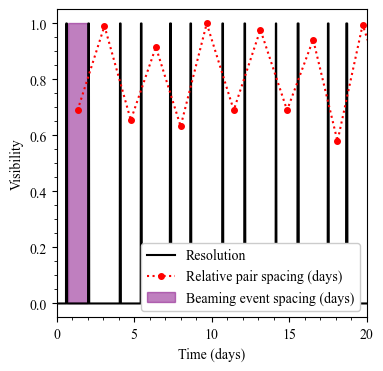

In [15]:
x1 = visibility_South[0]
x2 = visibility_South[1]
x = np.linspace(x1, x2, 100)
y = [1.0 for i in range(len(x))]


rect = plt.Rectangle((0.7, 0), 1.3, 1, 
                         edgecolor='purple', facecolor='purple', alpha=0.5, label='Beaming event spacing (days)')


fig = plt.figure(figsize=(4, 4))
plt.plot(times, visibility_South, 'k', label='Resolution')
plt.plot(xs,ys, 'ro:', markersize=4, label='Relative pair spacing (days)')
plt.gca().add_patch(rect)
plt.xlabel('Time (days)')
plt.ylabel('Visibility')
plt.xlim(0,20)
plt.legend(loc='lower right', framealpha=1)
plt.minorticks_on()
plt.show()


In [16]:
lower_curve_N = [yn[i] for i in range(0, len(yn),2)]
lower_times_N = [xn[i] for i in range(0, len(xn),2)]

lower_curve_S = [ys[i] for i in range(0, len(ys),2)]
lower_times_S = [xs[i] for i in range(0, len(xs),2)]

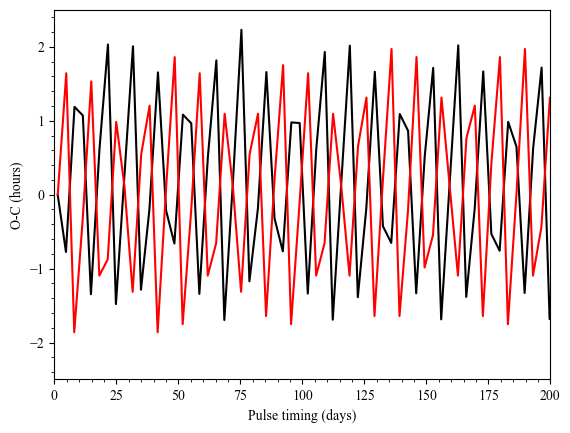

In [23]:
xn = g_durations_N 
yn = (g_centres_N/g_centres_N.max())
lower_times_N = [xn[i] for i in range(0, len(xn),2)]
mean_spacing_N = np.mean(np.diff(lower_times_N))

predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))
plt.plot(xn[::2], (xn[::2]-predicted_N)*24, 'k-')


xs = g_durations_S
ys = (g_centres_S/g_centres_S.max())
lower_times_S = [xs[i] for i in range(0, len(xs),2)]
mean_spacing_S = np.mean(np.diff(lower_times_S))

predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
plt.plot(xs[::2], (xs[::2]-predicted_S)*24, 'r-')
plt.xlabel('Pulse timing (days)')
plt.ylabel('O-C (hours)')
plt.xlim(0,200)
plt.ylim(-2.5,2.5)
plt.minorticks_on()
plt.show()

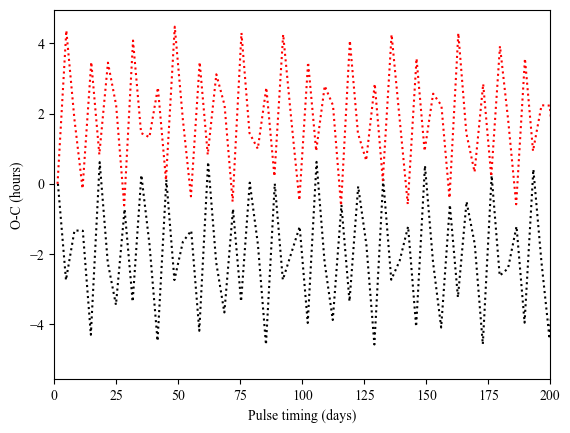

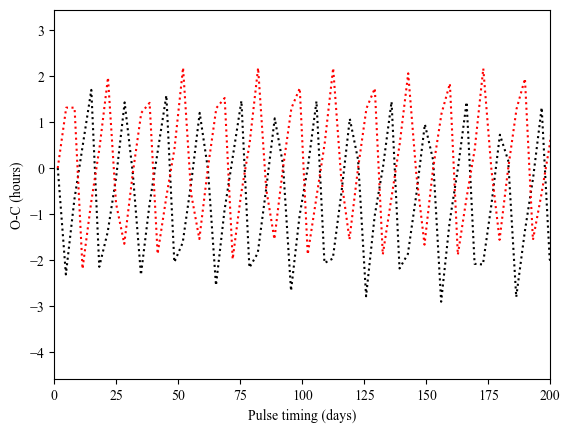

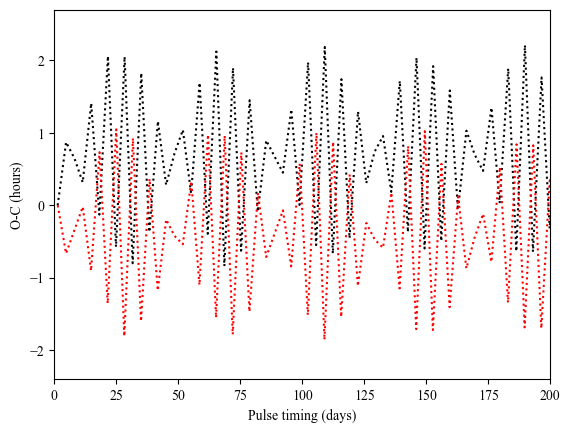

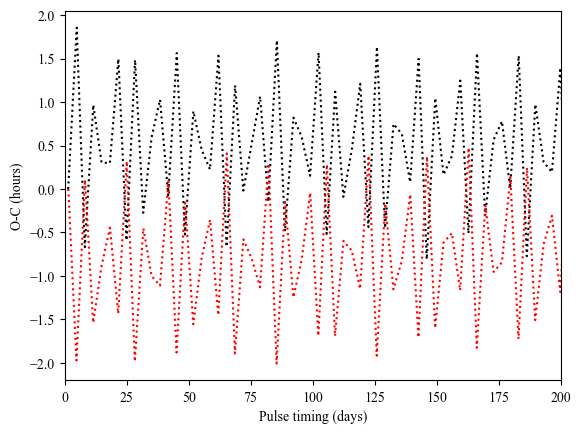

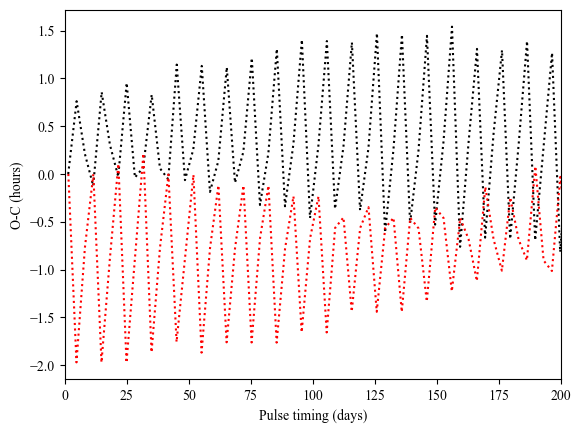

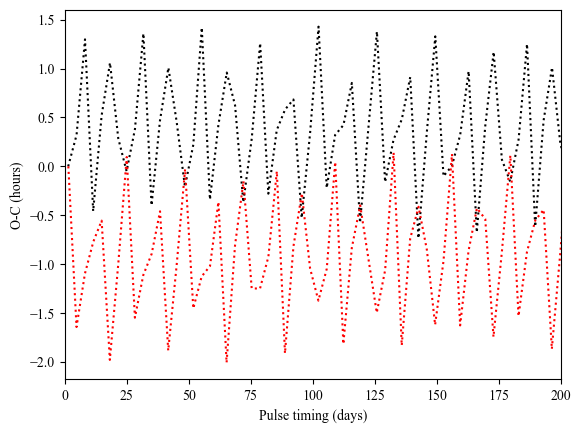

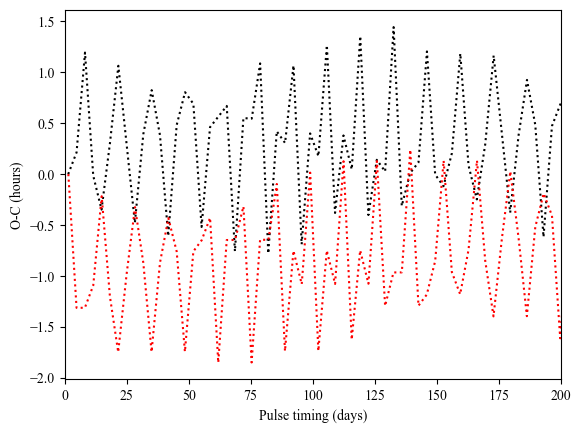

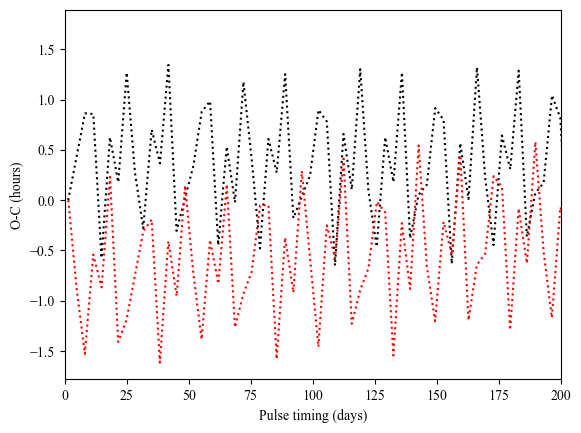

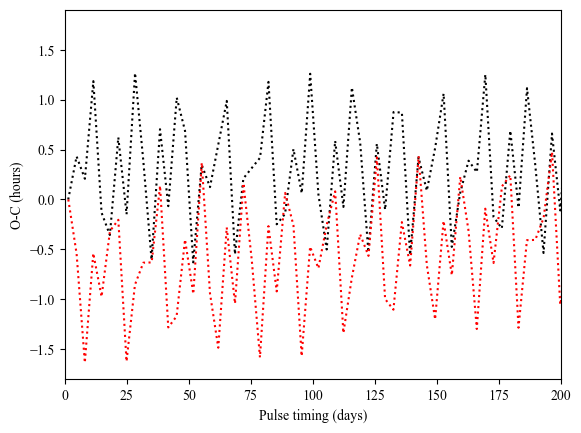

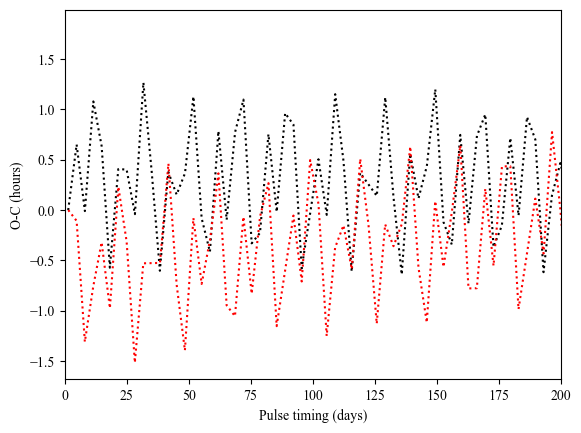

In [24]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 10)

for s in stellar_period:
    visibility_North, visibility_South = ms.maser(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0

    synodic_p = 1/(1/s - 1/P_p)

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)

        xn = g_durations_N 
        yn = (g_centres_N/g_centres_N.max())

        # lower_curve_N = yn[::2]
        # lower_times_N = xn[::2]

        mean_spacing_N = np.mean(np.diff(xn[::2]))

        predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))
    else:
        mean_spacing_N = np.nan
        xn = np.nan
        predicted_N = np.nan

    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)

        xs = g_durations_S
        ys = (g_centres_S/g_centres_S.max())

        # lower_curve_N = yn[::2]
        # lower_times_N = xn[::2]

        mean_spacing_S = np.mean(np.diff(xs[::2]))

        predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
    else:
        mean_spacing_S = np.nan
        xs = np.nan
        predicted_S = np.nan
    
    
    plt.plot(xn[::2], (xn[::2]-predicted_N)*24, 'k:')
    plt.plot(xs[::2], (xs[::2]-predicted_S)*24, 'r:')
    plt.xlabel('Pulse timing (days)')
    plt.ylabel('O-C (hours)')
    plt.xlim(0,200)
    plt.show()

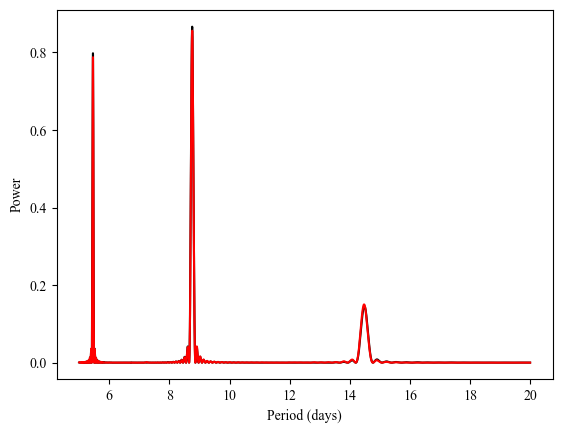

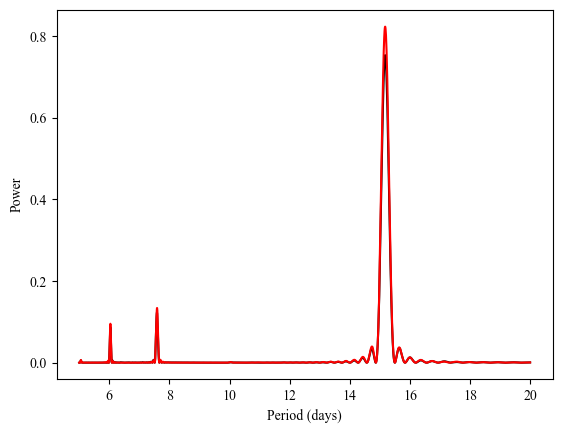

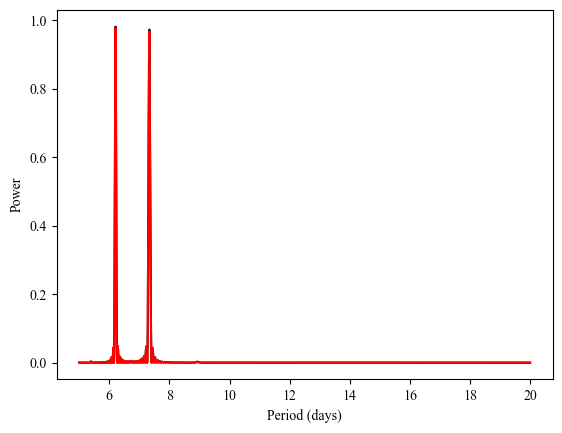

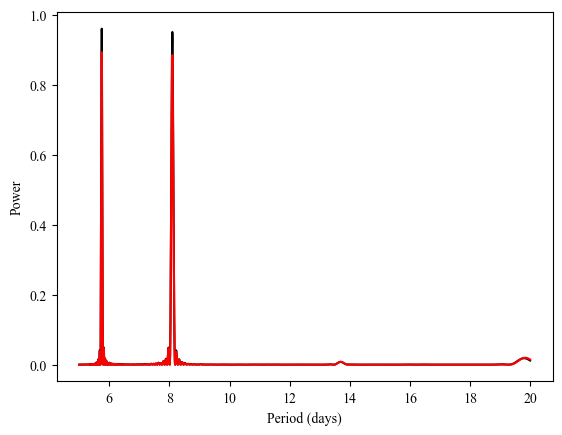

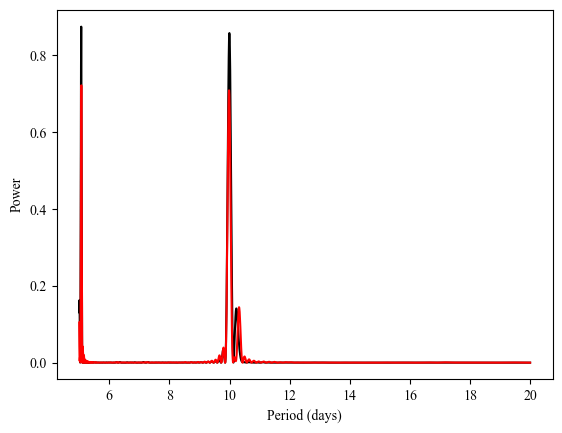

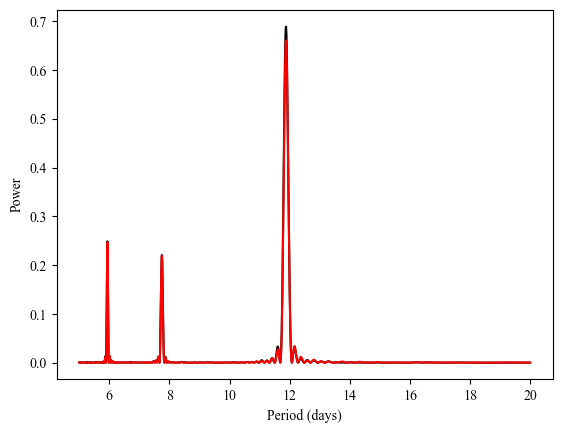

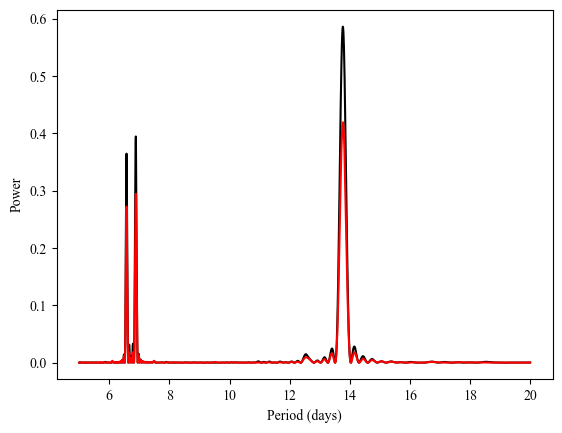

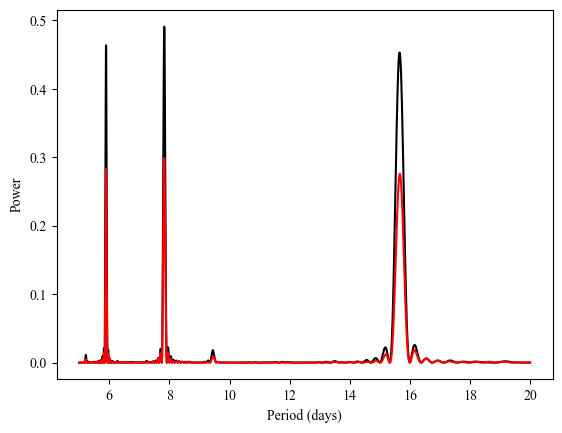

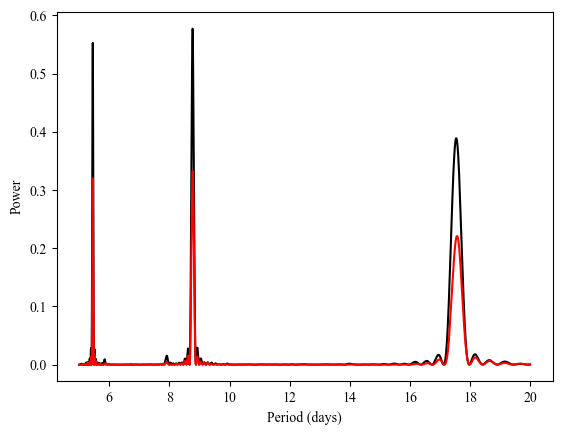

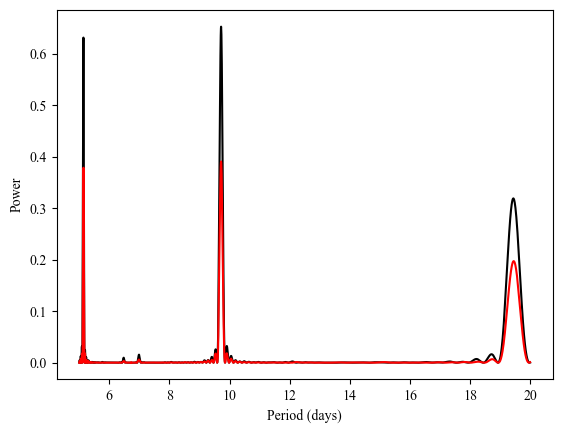

In [25]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 10)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies

for s in stellar_period:
    visibility_North, visibility_South = ms.maser(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0

    synodic_p = 1/(1/s - 1/P_p)

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)

        xn = g_durations_N 
        yn = (g_centres_N/g_centres_N.max())

        mean_spacing_N = np.mean(np.diff(xn[::2]))

        predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

        ominusc_n = xn[::2]-predicted_N
        ls_timing_n = LombScargle(xn[::2], ominusc_n)
        power_n = ls_timing_n.power(frequencies)
        best_period_n = period[np.argmax(power_n)]
    else:
        mean_spacing_N = np.nan
        xn = np.nan
        predicted_N = np.nan
        power_n = np.nan
        best_period_n = np.nan

    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)

        xs = g_durations_S
        ys = (g_centres_S/g_centres_S.max())

        mean_spacing_S = np.mean(np.diff(xs[::2]))

        predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
        ominusc_s = xs[::2]-predicted_S
        ls_timing_s = LombScargle(xs[::2], ominusc_s)
        power_s = ls_timing_s.power(frequencies)
        best_period_s = period[np.argmax(power_s)]
    else:
        mean_spacing_S = np.nan
        xs = np.nan
        predicted_S = np.nan
        power_s = np.nan
        best_period_s = np.nan
    
    
    plt.plot(period, power_n, 'k',label='North')
    plt.plot(period, power_s, 'r',label='South')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.show()

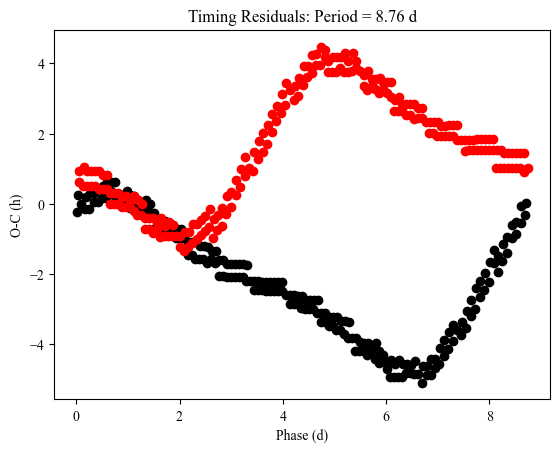

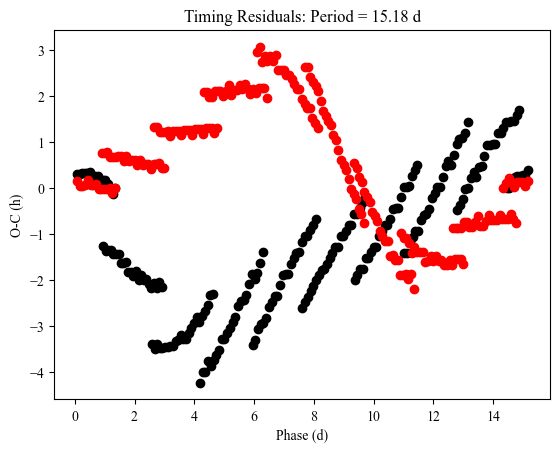

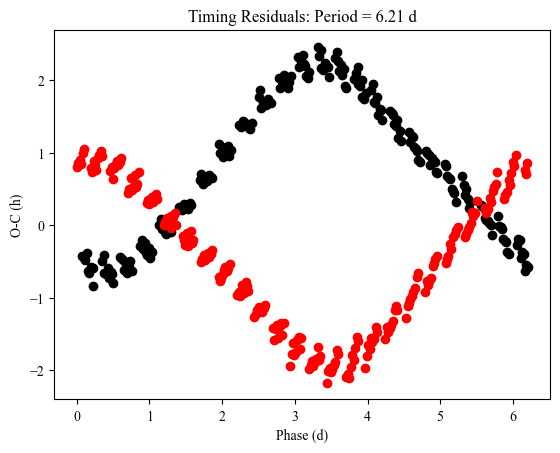

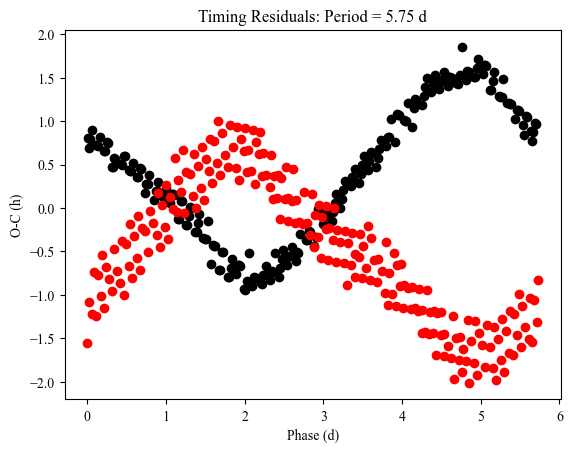

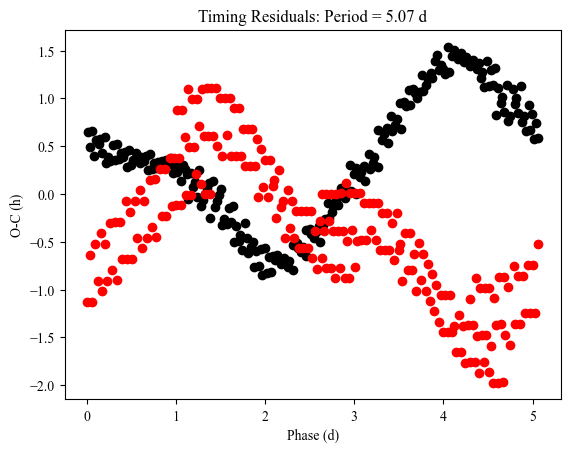

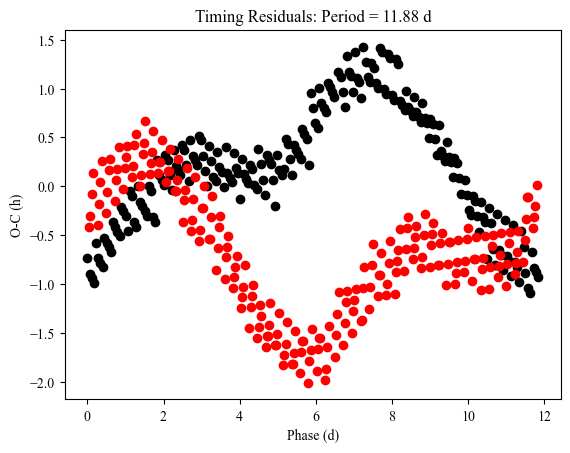

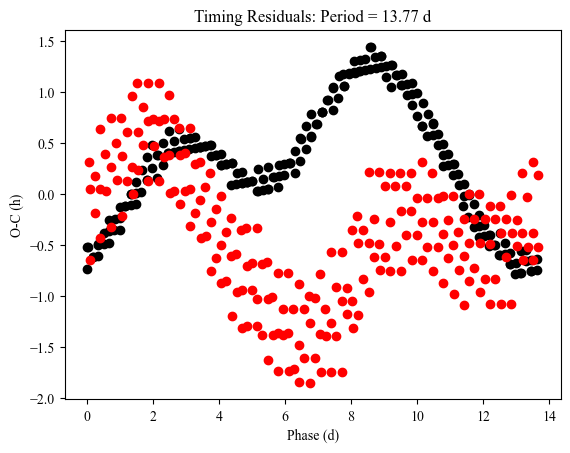

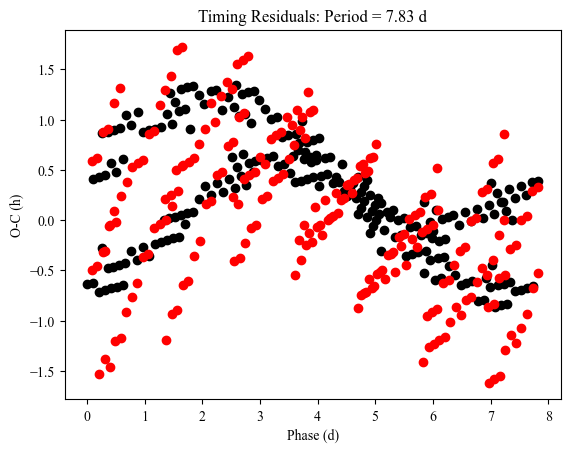

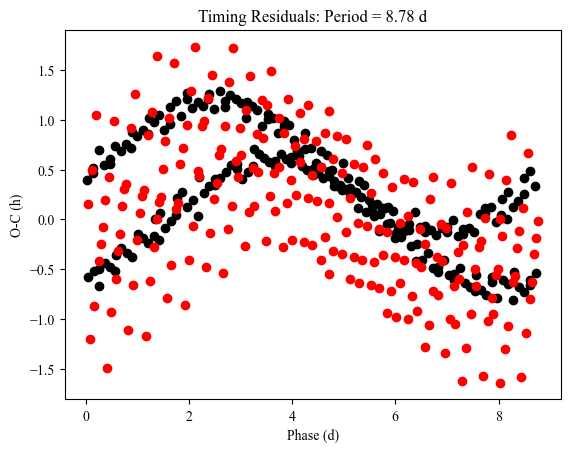

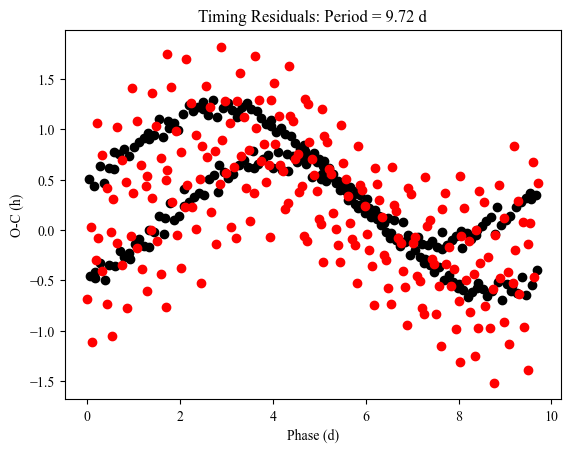

In [119]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 10)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies

for s in stellar_period:
    visibility_North, visibility_South = ms.maser(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0

    synodic_p = 1/(1/s - 1/P_p)

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)

        xn = g_durations_N 
        yn = (g_centres_N/g_centres_N.max())

        mean_spacing_N = np.mean(np.diff(xn[::2]))

        predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

        ominusc_n = xn[::2]-predicted_N
        ls_timing_n = LombScargle(xn[::2], ominusc_n)
        power_n = ls_timing_n.power(frequencies)
        best_period_n = period[np.argmax(power_n)]
    else:
        mean_spacing_N = np.nan
        xn = np.nan
        predicted_N = np.nan
        power_n = np.nan
        best_period_n = np.nan

    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)

        xs = g_durations_S
        ys = (g_centres_S/g_centres_S.max())

        mean_spacing_S = np.mean(np.diff(xs[::2]))

        predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
        ominusc_s = xs[::2]-predicted_S
        ls_timing_s = LombScargle(xs[::2], ominusc_s)
        power_s = ls_timing_s.power(frequencies)
        best_period_s = period[np.argmax(power_s)]
    else:
        mean_spacing_S = np.nan
        xs = np.nan
        predicted_S = np.nan
        power_s = np.nan
        best_period_s = np.nan
    
    
    plt.plot(xn[::2] % best_period_n,ominusc_n*24, 'ko')
    plt.plot(xs[::2] % best_period_s,ominusc_s*24, 'ro')
    plt.xlabel('Phase (d)')
    plt.ylabel('O-C (h)')
    plt.title('Timing Residuals: Period = {0:.2f} d'.format(best_period_s, best_period_n))
    plt.show()



In [81]:
def LS_periods(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period):
    visibility_North, visibility_South = ms.maser(M_s, R_s, stellar_period, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)

        xn = g_durations_N 

        mean_spacing_N = np.mean(np.diff(xn[::2]))
        mean_second_spacing_N = np.mean(np.diff(xn[::2],2))

        predicted_N = xn[0] + (mean_spacing_N)*np.arange(len(xn[::2]))

        ominusc_n = xn[::2]-predicted_N
        ls_timing_n = LombScargle(xn[::2], ominusc_n)
        power_n = ls_timing_n.power(frequencies)
        best_period_n = period[np.argmax(power_n)]
    else:
        mean_spacing_N = np.nan
        mean_second_spacing_N = np.nan
        best_period_n = np.nan

    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)

        xs = g_durations_S

        mean_spacing_S = np.mean(np.diff(xs[::2]))
        mean_second_spacing_S = np.mean(np.diff(xs[::2],2))

        predicted_S = xs[0] + (mean_spacing_S)*np.arange(len(xs[::2]))
        ominusc_s = xs[::2]-predicted_S
        ls_timing_s = LombScargle(xs[::2], ominusc_s)
        power_s = ls_timing_s.power(frequencies)
        best_period_s = period[np.argmax(power_s)]
    else:
        mean_spacing_S = np.nan
        best_period_s = np.nan
        mean_second_spacing_S = np.nan
    
    return mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S



In [83]:
stellar_period = np.linspace(0.5*P_s, 4*P_s, 100)
frequencies = np.geomspace(1/20,1/5,10000)
period = 1/frequencies

synodic_periods = []
mean_north_spacing = []
mean_south_spacing = []
mean_second_north_spacing = []
mean_second_south_spacing = []
best_north_period = []
best_south_period = [] 

for s in tqdm(stellar_period):
    mean_spacing_N, mean_spacing_S, best_period_n, best_period_s, mean_second_spacing_N, mean_second_spacing_S = LS_periods(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times, frequencies, period)
    
    synodic_p = 1/(1/s - 1/P_p)
    synodic_periods.append(synodic_p)
    mean_north_spacing.append(mean_spacing_N)
    mean_south_spacing.append(mean_spacing_S)
    mean_second_north_spacing.append(mean_second_spacing_N)
    mean_second_south_spacing.append(mean_second_spacing_S)
    best_north_period.append(best_period_n)
    best_south_period.append(best_period_s)


100%|██████████| 100/100 [09:06<00:00,  5.46s/it]


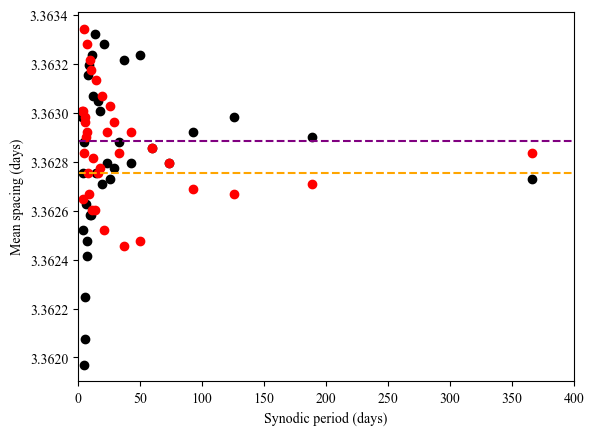

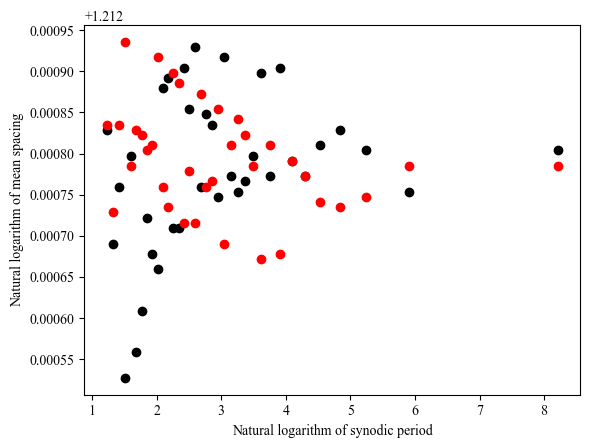

In [116]:
plt.plot(synodic_periods, mean_north_spacing, 'ko')
plt.plot(synodic_periods, mean_south_spacing, 'ro')
plt.ylabel('Mean spacing (days)')
plt.xlabel('Synodic period (days)')
plt.axhline(np.mean(mean_north_spacing), color='purple', linestyle='--')
plt.axhline(np.mean(mean_south_spacing), color='orange', linestyle='--')
plt.xlim(0,400)
plt.show()

plt.plot(np.log(synodic_periods), np.log(mean_north_spacing), 'ko')
plt.plot(np.log(synodic_periods), np.log(mean_south_spacing), 'ro')
plt.ylabel('Natural logarithm of mean spacing')
plt.xlabel('Natural logarithm of synodic period')
plt.show()

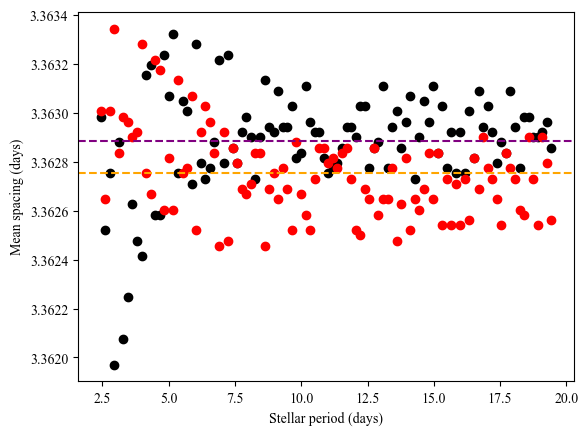

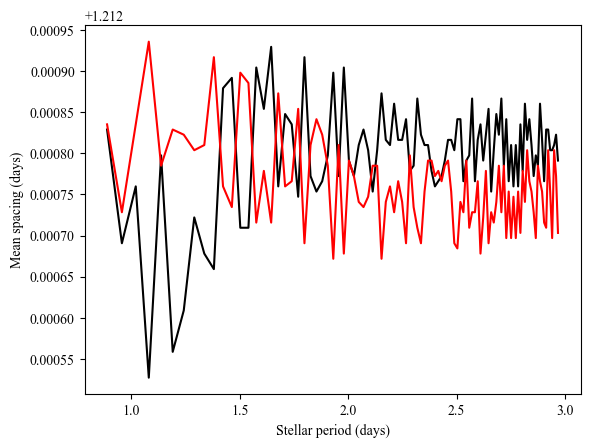

In [114]:

plt.plot(stellar_period, mean_north_spacing, 'ko')
plt.plot(stellar_period, mean_south_spacing, 'ro')
plt.axhline(np.mean(mean_north_spacing), color='purple', linestyle='--')
plt.axhline(np.mean(mean_south_spacing), color='orange', linestyle='--')
plt.ylabel('Mean spacing (days)')
plt.xlabel('Stellar period (days)')
plt.show()

plt.plot(np.log(stellar_period), np.log(mean_north_spacing), 'k-')
plt.plot(np.log(stellar_period), np.log(mean_south_spacing), 'r-')
plt.ylabel('Mean spacing (days)')
plt.xlabel('Stellar period (days)')
plt.show()

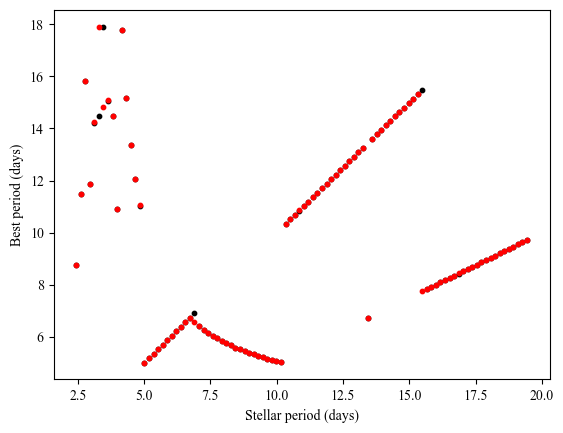

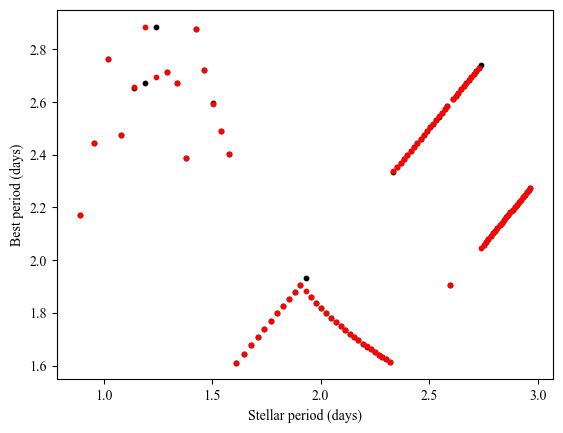

In [107]:
plt.scatter(stellar_period, best_north_period, color='k', s=10)
plt.scatter(stellar_period, best_south_period, color='r', s=10)
plt.ylabel('Best period (days)')
plt.xlabel('Stellar period (days)')
plt.show()


plt.scatter(np.log(stellar_period), np.log(best_north_period), color='k', s=10)
plt.scatter(np.log(stellar_period), np.log(best_south_period), color='r', s=10)
plt.ylabel('Best period (days)')
plt.xlabel('Stellar period (days)')
plt.show()


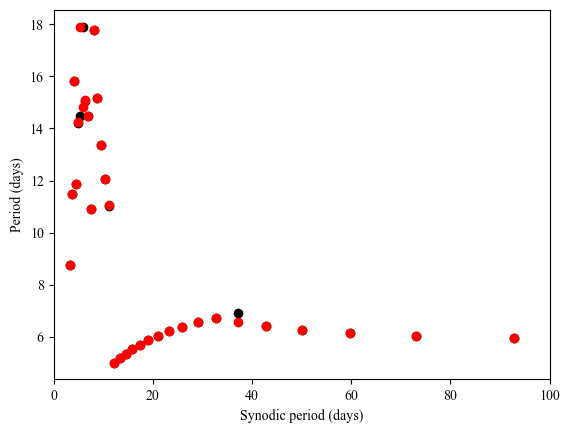

In [91]:
plt.plot(synodic_periods, best_north_period, 'ko')
plt.plot(synodic_periods, best_south_period, 'ro')
plt.ylabel('Period (days)')
plt.xlabel('Synodic period (days)')
plt.xlim(0,100)
plt.show()


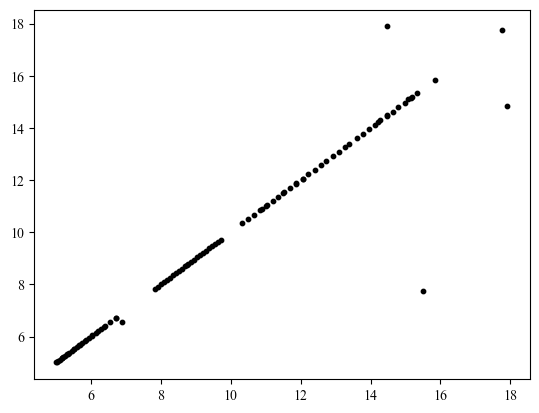

In [76]:
plt.scatter(best_north_period, best_south_period, color='k', s=10)
plt.show()

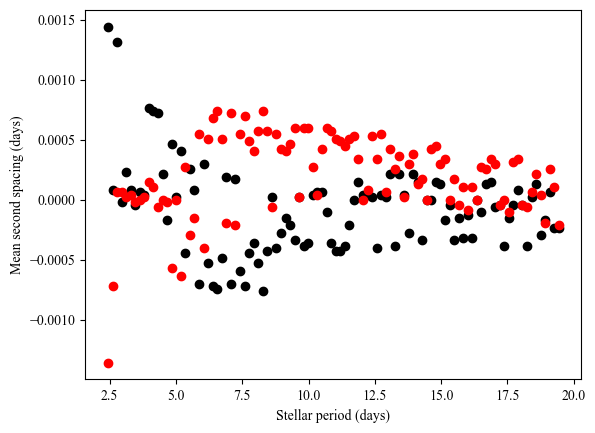

In [93]:
plt.plot(stellar_period, mean_second_north_spacing, 'ko')
plt.plot(stellar_period, mean_second_south_spacing, 'ro')
plt.ylabel('Mean second spacing (days)')
plt.xlabel('Stellar period (days)')
plt.show()

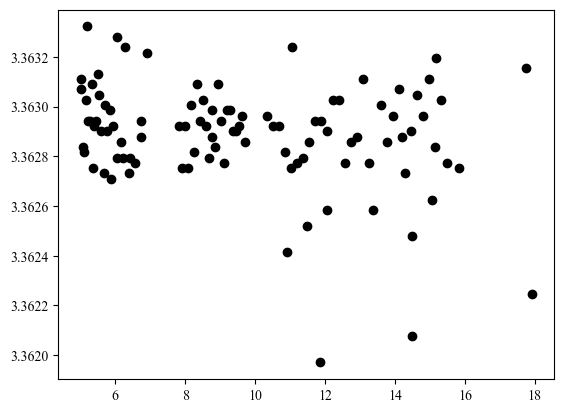

In [120]:
plt.plot(best_north_period, mean_north_spacing, 'ko')
plt.show()